## Computing Psychometric Predictive Power of Surprisal

This notebook will walk us through how to analyze how language surprisal predicts human reading times. The dataset contains eyetracking data for the Dundee corpus and self-paced reading data from the Natural Stories corpus. It has has been pre-processed for us (I can add code for this as well). In addition to surprisal, we will be using length and log frequency as predictors for reading time. To account for spillover effects (where previous information might affect processing of the current word), we also consider these three features for previous tokens.

In [30]:
library(ggplot2)
library(reshape2)
library(dplyr)
gpt2_data <- read.csv("gpt2_surprisal_rts.csv")

In [11]:
colnames(gpt2_data)

[1] "token"             "transcript_id"     "sentence_id"      
 [4] "surprisal"         "oov"               "num_tokens"       
 [7] "rt"                "token_uid"         "exclude_rt"       
[10] "word_length"       "log_freq"          "word"             
[13] "prev_freq_1"       "prev_len_1"        "prev_surprisal_1" 
[16] "prev_num_tokens_1" "corpus"            "prev_freq_2"      
[19] "prev_len_2"        "prev_surprisal_2"  "prev_num_tokens_2"
[22] "prev_freq_3"       "prev_len_3"        "prev_surprisal_3" 
[25] "prev_num_tokens_3" "prev_freq_4"       "prev_len_4"       
[28] "prev_surprisal_4"  "prev_num_tokens_4"

In [8]:
head(gpt2_data)

,token,transcript_id,sentence_id,surprisal,oov,num_tokens,rt,token_uid,exclude_rt,word_length,⋯,prev_surprisal_2,prev_num_tokens_2,prev_freq_3,prev_len_3,prev_surprisal_3,prev_num_tokens_3,prev_freq_4,prev_len_4,prev_surprisal_4,prev_num_tokens_4
,<chr>,<int>,<int>,<dbl>,<chr>,<int>,<dbl>,<int>,<int>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,renaissance,13,0,16.9963360,False,1,396.4000,1,0,11,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,in,13,0,4.7848325,False,1,163.2500,2,0,2,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,is,13,0,3.5461557,False,1,185.0000,5,0,2,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,turning,13,0,10.2781897,False,1,326.7778,6,0,7,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
5,out,13,0,2.4884927,False,1,186.8000,7,0,3,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
6,to,13,0,0.3600574,False,1,214.7500,8,0,2,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


We now separate the data by corpus.

In [19]:
dundee_gpt <- gpt2_data[gpt2_data$corpus == "dundee",]
natural_stories_gpt <- gpt2_data[gpt2_data$corpus == "natural_stories",]

We use formulas following [Wilcox et al (2020](https://arxiv.org/abs/2006.01912). We compute the psychometric predictive power as the per-token Delta Log Likelihood - or how much a model that considers surprisal as a feature improves over the control predictors of length and log frequency. This is the model's aggregate log likelihood normalized over the number of tokens in the corpus.

The formulas for Dundee and Natural Stories are different since the spillover effects for self paced reading data are longer than eyetracking data. So for the Dundee corpus we consider the previous word's surprisal, and for the Natural Stories corpus we look at the previous three words.

We use a generalized linear model (GLM), following previous work showing a linear relationship between surprisal and reading time. 

In [20]:
et_control_formula <- 'rt ~ log_freq * word_length + prev_freq_1 * prev_len_1'
et_surprisal_formula <- 'rt ~ surprisal + prev_surprisal_1 + log_freq * word_length + prev_freq_1 * prev_len_1'

spr_control_formula <- 'rt ~ log_freq * word_length + prev_freq_1 * prev_len_1 + prev_freq_2 * prev_len_2 + prev_freq_3 * prev_len_3'
spr_surprisal_formula <- 'rt ~ surprisal + prev_surprisal_1 + prev_surprisal_2 + prev_surprisal_3 + log_freq * word_length + prev_freq_1 * prev_len_1 + prev_freq_2 * prev_len_2 + prev_freq_3 * prev_len_3'

In [21]:
predictive_power <- function(data, control_formula, surprisal_formula, tokenization, log_values) {
    control_model <- glm(control_formula, data, family = 'gaussian')
    surprisal_model <- glm(surprisal_formula, data, family = 'gaussian')
    if (log_values) {
        print(tokenization)
        print(summary(surprisal_model)$coefficients)
    }
    (logLik(surprisal_model) - logLik(control_model)) / nrow(data)
}

Here, where we call the `predictive_power` function, we also get the features associated with the regression models. Overall, surprisal is a statistically significant predictor of reading time and the predictive power is over 1, so that tells us that surprisal does tell us something that word length and frequency don't. 

Results for the Dundee corpus

In [22]:
predictive_power(dundee_gpt, et_control_formula, et_surprisal_formula, "bpe", TRUE)

[1] "bpe"
                          Estimate Std. Error    t value     Pr(>|t|)
(Intercept)            220.2726663 4.25017300  51.826753 0.000000e+00
surprisal                1.8340967 0.09499248  19.307809 1.201773e-82
prev_surprisal_1         0.8558745 0.09024642   9.483750 2.596678e-21
log_freq                 5.5268917 0.95210122   5.804941 6.492396e-09
word_length             -0.7408914 0.69248186  -1.069907 2.846681e-01
prev_freq_1              2.4640931 0.95458146   2.581333 9.845835e-03
prev_len_1              -8.8410591 0.70087316 -12.614350 2.099166e-36
log_freq:word_length    -2.7657004 0.16713078 -16.548122 2.772926e-61
prev_freq_1:prev_len_1  -1.1447509 0.16959805  -6.749788 1.502861e-11


'log Lik.' 0.006696996 (df=10)

Results for the Natural Stories corpus

In [23]:
predictive_power(natural_stories_gpt, spr_control_formula, spr_surprisal_formula, "bpe", TRUE)

[1] "bpe"
                           Estimate Std. Error    t value     Pr(>|t|)
(Intercept)            317.67153186 6.89744827 46.0563848 0.000000e+00
surprisal                1.03500218 0.09937174 10.4154583 3.356685e-25
prev_surprisal_1         0.45831894 0.09285295  4.9359651 8.178487e-07
prev_surprisal_2         0.12933909 0.08762222  1.4760992 1.399667e-01
prev_surprisal_3         0.07842217 0.08743729  0.8968962 3.698082e-01
log_freq                 3.70192901 0.99005608  3.7391104 1.862929e-04
word_length             -3.88473964 0.78228422 -4.9658929 7.016736e-07
prev_freq_1              0.71545150 1.02279355  0.6995072 4.842606e-01
prev_len_1              -2.24576078 0.80689800 -2.7832028 5.398384e-03
prev_freq_2             -0.75211580 0.98009692 -0.7673892 4.428786e-01
prev_len_2               0.14034742 0.79757645  0.1759674 8.603252e-01
prev_freq_3              0.41829672 0.95890954  0.4362213 6.626910e-01
prev_len_3              -0.91624883 0.78640404 -1.1651121 2.440173e

'log Lik.' 0.01084273 (df=18)

One issue with training one regression model on the entire dataset is that it is being evaluated on data it was trained on. To address this issue, we perform 10-fold cross-validation, where a model is trained on a random selection of 9/10 of the data and evaluated on 1/10 of the data. This process runs 10 times, such that each tenth of the data gets to be the validation set. We then make a boxplot of the predictive power values.

In [24]:
test_data_loglik <- function(model, test_data) {
    predictions <- predict(model, test_data)
    stdev <- sigma(model)
    dnorm(test_data$rt, predictions, stdev, log = TRUE)
}

cross_validate <- function(data, indices, control_formula, surprisal_formula) {
    data<-data[indices,]
    folds <- cut(seq(1,nrow(data)),breaks=10,labels=FALSE) # this is the same for each model
    predictive_power <- seq(1:10)
    for(i in 1:10){
        test_indices <- which(folds==i)
        test_data <- data[test_indices, ]
        train_data <- data[-test_indices, ]
        fold_control_model <- glm(control_formula, train_data, family = 'gaussian')
        fold_surprisal_model <- glm(surprisal_formula, train_data, family = 'gaussian')
        surprisal_diff <- test_data_loglik(fold_surprisal_model, test_data) - test_data_loglik(fold_control_model, test_data)
        predictive_power[i] <- mean(surprisal_diff) # summed per-token log likelihoods, divided by number of tokens 
        }
    predictive_power
}

In [31]:
dundee_shuffled <- sample(nrow(dundee_gpt))
ns_shuffled <- sample(nrow(natural_stories_gpt))
cv_results <- data.frame(dundee = cross_validate(dundee_gpt, dundee_shuffled, et_control_formula, et_surprisal_formula),
natural_stories = cross_validate(natural_stories_gpt, ns_shuffled, spr_control_formula, spr_surprisal_formula)
)
cv_results <- melt(cv_results)

No id variables; using all as measure variables



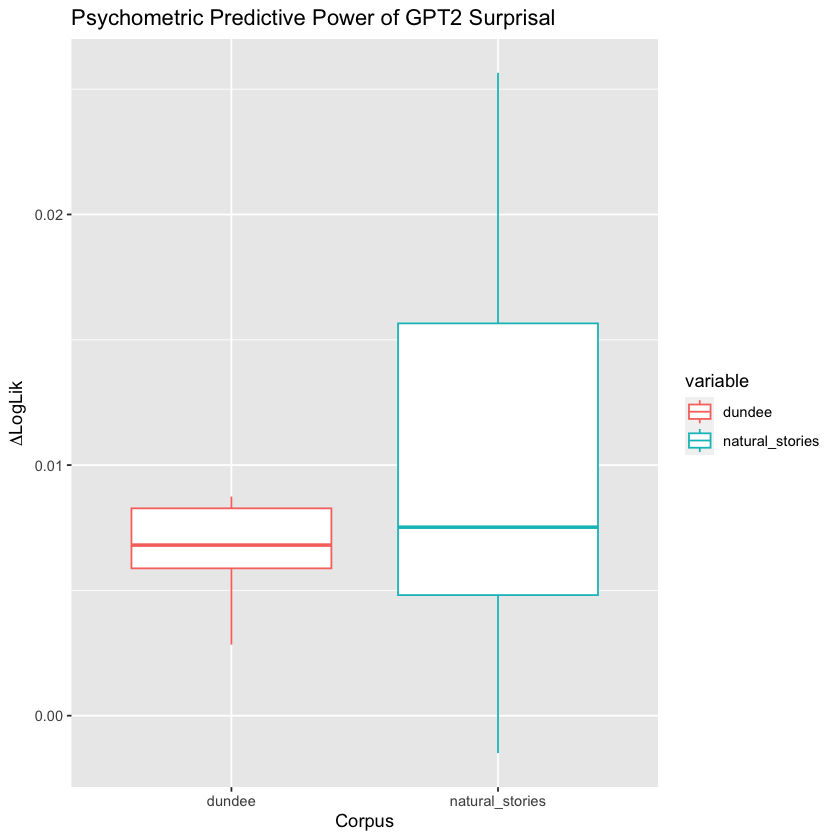

In [36]:
plot <- ggplot(cv_results, aes(x=variable, y = value, color = variable)) + geom_boxplot()
plot + ylab(expression(paste(Delta, "LogLik"))) + xlab("Corpus") + labs(title = "Psychometric Predictive Power of GPT2 Surprisal")

The Natural Stories corpus is larger and more syntactically complex, so the variance in predictive power could be higher for this reason.